In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import holidays

In [2]:
def build_features(df):
    daily_df = (df.groupby('datetime').agg(total_sales=('Sales', 'sum'), avg_discount=('Discount', 'mean')).reset_index())
    daily_df['total_sales'] = np.log1p(daily_df['total_sales'])
    # Fill all days
    all_days_range = pd.date_range(start=daily_df['datetime'].min(), end=daily_df['datetime'].max()) 
    all_days = pd.DataFrame({'datetime': all_days_range})
    # Merge with your daily data
    daily_df = all_days.merge(daily_df, on='datetime', how='left')

    # Replace NaN (days with no sales) by 0
    daily_df['total_sales'] = daily_df['total_sales'].fillna(0)

    # year
    daily_df['year'] = daily_df['datetime'].dt.year

    # month
    daily_df['month'] = daily_df['datetime'].dt.month
    daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['month'] / 12)
    daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['month'] / 12)
    daily_df.drop('month', axis = 1, inplace = True)

    # week
    daily_df['week_of_month'] = daily_df['datetime'].apply(lambda d: (d.day - 1) // 7 + 1)
    daily_df['week_of_month_sin'] = np.sin(2 * np.pi * daily_df['week_of_month'] / 12)
    daily_df['week_of_month_cos'] = np.cos(2 * np.pi * daily_df['week_of_month'] / 12)
    daily_df.drop('week_of_month', axis = 1, inplace = True)

    # day of week
    daily_df['day_of_week'] = daily_df['datetime'].dt.dayofweek 
    daily_df['day_of_week_sin'] = np.sin(2 * np.pi * daily_df['day_of_week'] / 12)
    daily_df['day_of_week_cos'] = np.cos(2 * np.pi * daily_df['day_of_week'] / 12)
    daily_df.drop('day_of_week', axis = 1, inplace = True)

    # is discount
    daily_df['is_discount'] = daily_df['avg_discount'] > 0


    # holiday
    us_holidays  = holidays.CountryHoliday('US', years=range(2013, 2020))
    canada_holidays = holidays.CountryHoliday('CA', years=range(2013, 2020))
    holiday_dates =list(canada_holidays.keys())
    holiday_dates.append(list(us_holidays.keys()))
    daily_df['is_holiday'] = daily_df['datetime'].dt.date.isin(holiday_dates)

    # lag1
    daily_df['lag1'] = daily_df['total_sales'].shift(1)

    # lag7
    daily_df['lag7'] = daily_df['total_sales'].shift(7)

    # Fill NaN avg discounts
    daily_df['avg_discount'] = daily_df['avg_discount'].fillna(0)
    
    return daily_df

In [3]:
train_data_path = '../data/train_data.csv'
raw_df = pd.read_csv(train_data_path)
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

df = build_features(raw_df)

# Start at day 7 to avoid NaNs in lag7
df = df.iloc[7:]


In [4]:
features = [f for f in df.columns if f != 'datetime']
data = df[features].values
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30   # for example, use past 12 months
X, y = create_sequences(data_scaled, SEQ_LENGTH)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Model
input_size = X.shape[2]  # number of features

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout = 0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



# Data loader
from torch.utils.data import Dataset, DataLoader
import torch

class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SalesDataset(X_train, y_train)
val_dataset = SalesDataset(X_val,y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Loss function 
import torch.nn as nn
import torch.optim as optim

input_size = X.shape[2]      # number of features per day
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()           # regression loss
optimizer = optim.Adam(model.parameters(), lr=100e-5)


num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)

        weights = torch.where(y_batch > 0, 5.0, 1.0)
        weights = weights / weights.mean()
        loss = (weights * (y_pred.squeeze() - y_batch) ** 2).mean()
        #loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            weights = torch.where(y_batch > 0, 5.0, 1.0)
            weights = weights / weights.mean()
            loss = (weights * (y_pred.squeeze() - y_batch) ** 2).mean()
            val_loss += loss.mean().item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    # ---- Track progress ----
    print(f"Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch 1/100 | Train: 0.0995 | Val: 0.0539
Epoch 2/100 | Train: 0.0718 | Val: 0.0530
Epoch 3/100 | Train: 0.0736 | Val: 0.0586
Epoch 4/100 | Train: 0.0727 | Val: 0.0528
Epoch 5/100 | Train: 0.0704 | Val: 0.0533
Epoch 6/100 | Train: 0.0723 | Val: 0.0519
Epoch 7/100 | Train: 0.0717 | Val: 0.0515
Epoch 8/100 | Train: 0.0696 | Val: 0.0541
Epoch 9/100 | Train: 0.0704 | Val: 0.0562
Epoch 10/100 | Train: 0.0697 | Val: 0.0523
Epoch 11/100 | Train: 0.0702 | Val: 0.0564
Epoch 12/100 | Train: 0.0699 | Val: 0.0499
Epoch 13/100 | Train: 0.0687 | Val: 0.0504
Epoch 14/100 | Train: 0.0689 | Val: 0.0503
Epoch 15/100 | Train: 0.0693 | Val: 0.0491
Epoch 16/100 | Train: 0.0696 | Val: 0.0493
Epoch 17/100 | Train: 0.0690 | Val: 0.0500
Epoch 18/100 | Train: 0.0676 | Val: 0.0504
Epoch 19/100 | Train: 0.0671 | Val: 0.0494
Epoch 20/100 | Train: 0.0674 | Val: 0.0489
Epoch 21/100 | Train: 0.0676 | Val: 0.0519
Epoch 22/100 | Train: 0.0671 | Val: 0.0478
Epoch 23/100 | Train: 0.0657 | Val: 0.0485
Epoch 24/100 | Train

In [5]:
y_batch

tensor([0.6397, 0.4863, 0.6714, 0.6805, 0.3244, 0.0000, 0.0000, 0.4909, 0.7102,
        0.8166, 0.6244])

In [6]:
# Test

test_data_path = '../data/test_data.csv'
raw_test_df = pd.read_csv(test_data_path)
raw_test_df['datetime'] = pd.to_datetime(raw_test_df['datetime'])
test_beginning = raw_test_df['datetime'].min()
combined_df = pd.concat([raw_df, raw_test_df])

processed_df = build_features(combined_df)
test_df = processed_df[processed_df['datetime'].dt.date >= test_beginning.date()]
# Start at day 7 to avoid NaNs in lag7
data_test = test_df[features].values


# Normalize

data_scaled_test = scaler.transform(data_test)
data_combined = np.vstack([data_scaled[-SEQ_LENGTH:], data_scaled_test])


X_test, y_test = create_sequences(data_combined, SEQ_LENGTH)



predictions = []
true_values = []

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor).squeeze().numpy()




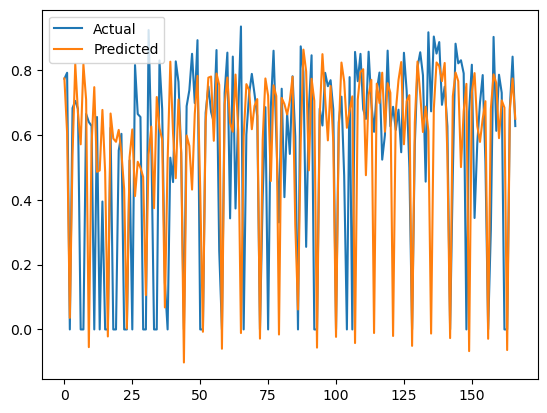

In [7]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
#plt.xlim([0, 25])
plt.show()
